# Title

## Introduction

**Question**: How do age and experience level predict the number of hours played?

## Methods & Results

In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

First, we will use the read function to get the dataframes from the link.

In [17]:
# Read players.csv
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

# Read sessions.csv
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To answer our quesiton, we are going to select the variables experience, played hours, and age to create the dataframe we will use for our prediction.

In [3]:
players_select <- players |>
    select(played_hours, age, experience)

players_select

played_hours,age,experience
<dbl>,<dbl>,<chr>
30.3,9,Pro
3.8,17,Veteran
0.0,17,Veteran
⋮,⋮,⋮
0.0,17,Amateur
2.3,17,Amateur
0.2,91,Pro


In [ ]:
We will change experience to a numeric variable. It is an ordinal variable and we are assigning each category a number so that
we can put them on the x-axis of a graph.

In [4]:
players_tidy <- mutate(players_select, experience_num = as.numeric(as.factor(experience)))
players_tidy

played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Pro,3
3.8,17,Veteran,5
0.0,17,Veteran,5
⋮,⋮,⋮,⋮
0.0,17,Amateur,1
2.3,17,Amateur,1
0.2,91,Pro,3


Now we're going to plot Age and Experience with respect to played_hours to get a general idea of our plot and to see which prediction method to use. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


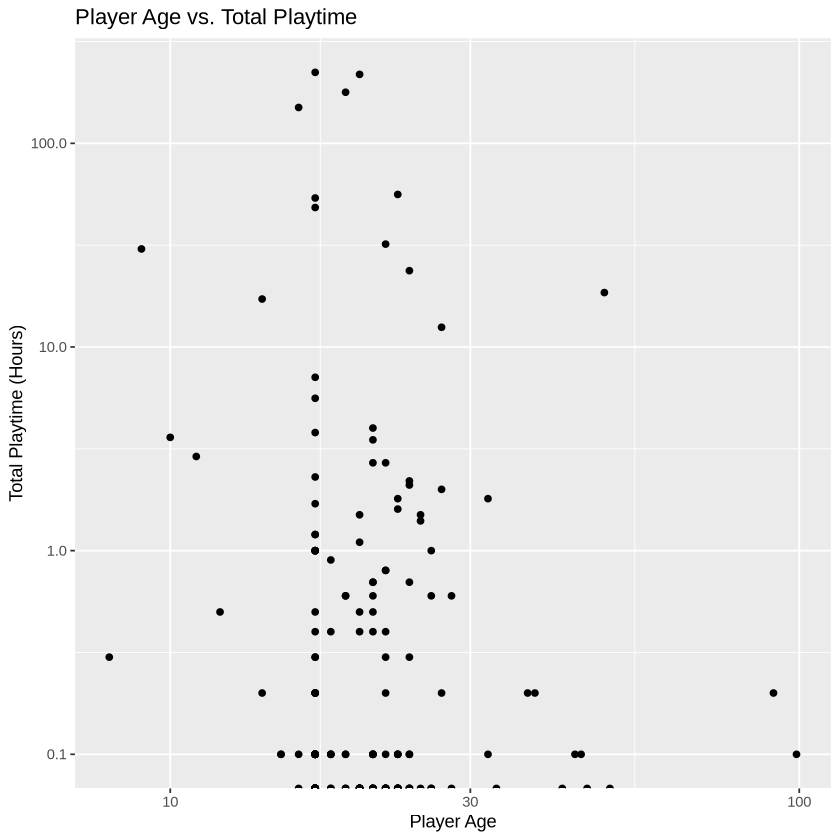

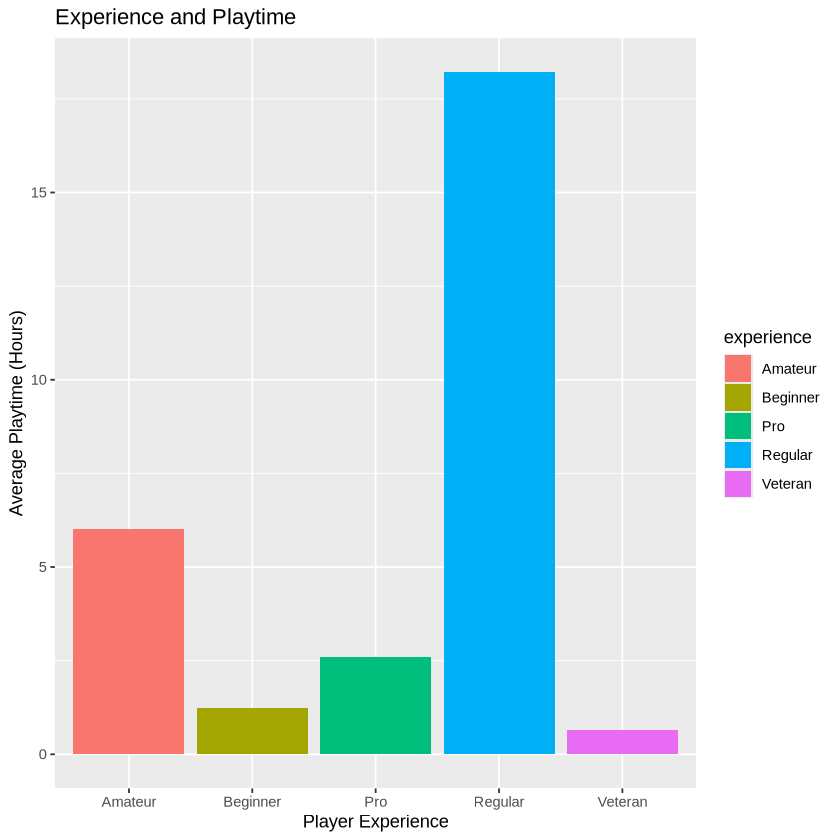

In [19]:
# Age Plot

demographics_playtime_plot <- players_tidy |>
ggplot(aes(x=age, y=played_hours, )) +
scale_x_log10() +
scale_y_log10() +
labs(x= "Player Age",
     y="Total Playtime (Hours)",
    title="Player Age vs. Total Playtime") +
geom_point()
demographics_playtime_plot

# Experience Plot

experience_level_avgs <- players_tidy |> 
group_by(experience) |>
summarize(avg_total_playtime = mean(played_hours))

experience_playtime_plot <- experience_level_avgs |>
ggplot(aes(x=experience, y=avg_total_playtime, fill=experience)) +
labs(x= "Player Experience",
     y="Average Playtime (Hours)",
    title="Experience and Playtime") +
geom_bar(stat = "identity", position = "dodge")
experience_playtime_plot


We notice that there is no distinct linear relationship within the two graphs. Therefore, we conclude that KNN regression be the best predictive model to use in predicting hours played from the predictive variables "experience" and "age".

We can start building up our knn-regression model. First step is going to be creating our training and testing data.

In [13]:
players_new <- mutate(players_select, experience_num = as.numeric(as.factor(experience)))
players_new

played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Pro,3
3.8,17,Veteran,5
0.0,17,Veteran,5
⋮,⋮,⋮,⋮
0.0,17,Amateur,1
2.3,17,Amateur,1
0.2,91,Pro,3


After converting the experience into numberical values we can start building up our knn-regression model. First step is going to be creating our training and testing data.


In [14]:
#initial split
players_split <- initial_split(players_new, prop = .75, strata = played_hours)

# Training data
players_training <- training(players_split)
#Testing Data
players_testing <- testing(players_split)

players_training
players_testing

ERROR: Error in initial_split(players_new, prop = 0.75, strata = played_hours): could not find function "initial_split"


In [ ]:
set.seed(1234)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_recipe <- recipe(played_hours ~ age + experience_num, data = players_new) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(1,10, by = 1))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

In [ ]:
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
players_min

In [ ]:
set.seed(1234) # DO NOT REMOVE

k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)

players_summary

## Discussion

In [ ]:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

## References